In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

In [14]:
# split a univariate sequence into samples
def split_inputs(sequence, window_size):
    left_input, right_input = list(), list()
    for i in range(0, len(sequence), window_size):
        # find the end of this pattern
        end_ix = i + (2*window_size)
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_left, seq_right = sequence[i:i+window_size], sequence[i+window_size:end_ix]
        left_input.append(seq_left)
        right_input.append(seq_right)
    return np.array(left_input), np.array(right_input)

In [15]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [16]:
dfs = []
for i in range(1, 68):
    dfs.append(pd.read_csv('./data/A1Benchmark/real_{}.csv'.format(i), index_col='timestamp'))

In [17]:
# Q1, Q3 = np.quantile(df.value.to_numpy(), [0.1]), np.quantile(df.value.to_numpy(), [0.99])
# Q1, Q3

In [21]:
train, test = dfs[0].value.iloc[:1000], dfs[0].value.iloc[1000:]

In [22]:
train_left_input, train_right_input = split_inputs(train, 5)
test_left_input, test_right_input = split_inputs(test, 5)

In [20]:
n_features = 1
n_steps = 3

In [26]:
X_train, y_train = split_sequence(train.to_numpy(), n_steps=n_steps)
X_test, y_test = split_sequence(test.to_numpy(), n_steps=n_steps)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))

In [23]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense
# define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [25]:
# fit model
model.fit(X_train, y_train, epochs=200, verbose=0)

In [27]:
y_hat = model.predict(X_test, verbose=0)

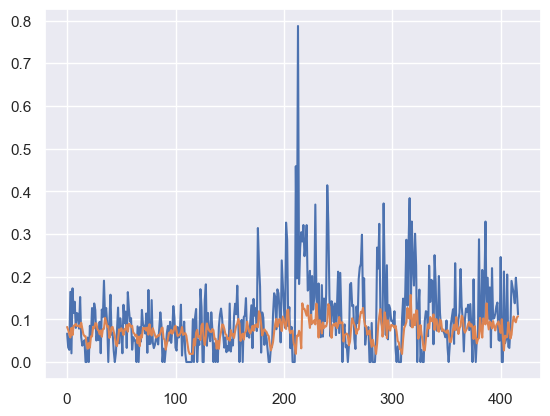

In [28]:
plt.plot(y_test)
plt.plot(y_hat)